Vincent ROCA vincent.roca@univ-lille.fr

# Introduction

In this session, we use Python to visualize and manipulate MRI data. MRI data can be downloaded at [this adress](https://nextcloud.univ-lille.fr/index.php/s/Tsaape5DmBtFaze).

# Exploration of the dataset

We will first explore the file **metadata.csv** in the data directory to compute and display some statistics relative to the dataset. Each line in this file corresponds to a patient with an MR image.

## Data loading

Load the CSV file into a **pandas DataFrame**. Print the number of patients and the column names.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt 
df = pd.read_csv('metadata.csv')

In [2]:
df.head()

,sub_id,site,age,sex
0,1,NMorph,35.00,M
1,2,Guys,22.43,M
2,3,Biograph,72.00,F
3,4,Biograph,68.00,F
4,5,Biograph,79.00,F


## Global statistics

Print some statistics:
  - average age
  - standard deviation of age
  - percentage of women

In [3]:
print( 'The average age is %.3f' % df['age'].mean())
print('the standard deviation value is %.3f' % df['age'].std())
print((df['sex']=='F').sum()/df.shape[0]*100)

The average age is 50.600
the standard deviation value is 16.955
50.0


## Statistics per site

The *site* field in metadata enables to identify the site of MR image acquisition for each patient.

Print the list of site names and the number of patients for each one. The [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and [size](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.size.html) functions may be helpful.

In [4]:
df.groupby("site")["sub_id"].size()

site
Biograph    5
Guys        5
HH          5
NMorph      5
Name: sub_id, dtype: int64

Print the following statistics for each site:
  - average age
  - standard deviation of age
  - percentage of women
  
The [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and [aggregate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html) functions may be helpful.

In [5]:
print(df.groupby('site')[["age"]].agg(lambda x: x.astype(float).mean()))
print(df.groupby('site')[["age"]].agg(lambda x: x.astype(float).std()))
# print(df.groupby('site')[["age"]].agg(lambda x: x.astype(float).std()))

             age
site            
Biograph  68.200
Guys      48.174
HH        49.626
NMorph    36.400
                age
site               
Biograph  10.425929
Guys      17.510589
HH        14.577837
NMorph     9.476286


Display boxplots of age distribution for each site. **seaborn.boxplot** may be helpful.

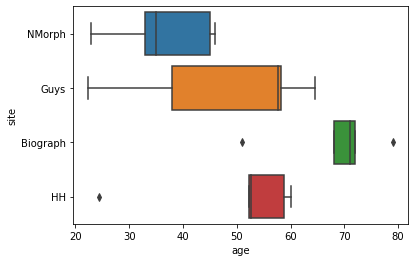

In [6]:
import seaborn as sns
ax = sns.boxplot(x="age", y="site", data=df)

# Manipulation/visualization of an MR image and segmentation masks

We will now work on 3 MR images of subject 2:
  1. **2_raw.nii.gz**: MR image of subject 2
  2. **2_brainMask.nii.gz**: corresponding brain mask. $mask[i,j,k] > 0$ means that $brain[i,j,k]$ has been identified as a brain voxel.
  3. **2_seg.nii.gz**: corresponding segmentation mask. Identifies the type of brain tissue in the brain:
      - $mask[i,j,k] = 0 \rightarrow$ non-brain voxel
      - $mask[i,j,k] = 1 \rightarrow$ cerebrospinal fluid (CSF) voxel
      - $mask[i,j,k] = 2 \rightarrow$ gray-matter (GM) voxel
      - $mask[i,j,k] = 3 \rightarrow$ white-matter (WM) voxel

## Data loading

Load the 3 MR images into 3 **numpy.ndarray** with **nibabel.load**.

In [17]:
import nibabel as nib

In [18]:
img1 = nib.load('2_raw.nii.gz')
img2 = nib.load('2_brainMask.nii.gz')
img3 = nib.load('2_seg.nii.gz')

mri_raw_data = img1.get_fdata()
mri_brain_mask_data = img2.get_fdata()
mri_seq_data = img3.get_fdata()

In [19]:
print(img1.shape), print(img2.shape), print(img3.shape)

(256, 256, 150)
(256, 256, 150)
(256, 256, 150)


(None, None, None)

## Skullstripping

Use the brain mask to set all non-brain voxels to 0 (skullstripping). Store the result in a new *numpy.ndarray*. **numpy.where** may be helpful.

In [20]:
brain_data =np.where(img2==0, 0,img1.get_fdata())

## Visualization

Use the **imshow** function of *matplotlib* (with `cmap='gray'`) to display a slice (2D image) of the raw image, the skullstripped image and the segmentation. Use the same slice position for the 3 images (e.g. `array[:,:,75]`).

Note: You can use [subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) and [Axes.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) to display the three images on one row.

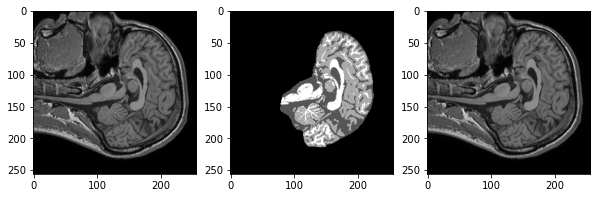

In [21]:
image_data=[brain_data[:,:,75],img3.get_fdata()[:,:,75]]
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(brain_data[:,:,75],cmap='gray')
axs[1].imshow(img3.get_fdata()[:,:,75],cmap='gray')
axs[2].imshow(img1.get_fdata()[:,:,75],cmap='gray')

In [22]:
#example to check 
a=np.arange(12)  
b=np.where(a<6,a,2*a)  
b, a

(array([ 0,  1,  2,  3,  4,  5, 12, 14, 16, 18, 20, 22]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

#  Histogram of intensities

Create a function `compute_histogram` for computing histograms of intensities (voxel values). This function takes 3 arguments:
  - `mri`: *numpy.ndarray* corresponding to the MRI
  - `mask`: *numpy.ndarray* of booleans corresponding to voxels of interest
  - `bins`: array of bin edges of the resulting histogram
  
The function returns the values of the histogram of intensities inside the region defined by `mask`. Call **numpy.histogram** inside this function.

In [23]:
def compute_histogram(mri,mask,bins):
    mri_data = mri.flatten()
    mask_data = mask.flatten()
    mri_hist = mri_data[mask_data]
    hist, bins = np.histogram(mri_hist,bins=bins)
    return hist

The following function will be used to plot histograms (you can adapt it if you want):

In [24]:
import numpy as np
import matplotlib.pyplot as plt
def plot_histogram(hist, bins, label=None):
    hist = np.insert(hist, 0, hist[0])
    plt.plot(bins, hist, drawstyle='steps', label=label)

## Single subject

Use these two functions to plot the histogram of **brain** intensities of the subject 2. We will use the following histogram bin edges `np.arange(start=0, stop=1600, step=30)`.

In [25]:
bins = np.arange(start=0, stop=1600, step=30)

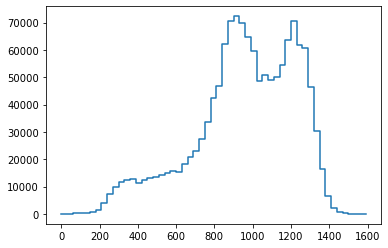

In [26]:
mask_bool = np.where(mri_brain_mask_data > 0, True, False)
hist = compute_histogram(mri_raw_data, mask_bool, bins)
plot_histogram(hist, bins)

Now use these two functions and the segmentation matrix you previously loaded (*2_seg.nii.gz*) to plot 3 histograms for subject 2 in one figure:
  - CSF intensities
  - GM intensities
  - WM intensities
  
Note: You can use the `label` parameter of `compute_histogram` and the *matplotlib.pyplot.legend* function.

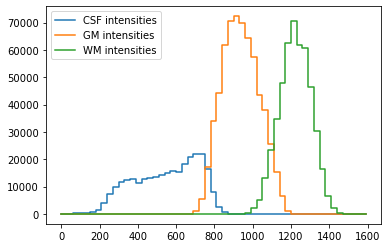

In [27]:
mask_bool_CSF = np.where(mri_seq_data == 1, True, False)
mask_bool_GM = np.where(mri_seq_data == 2, True, False)
mask_bool_WM = np.where(mri_seq_data == 3, True, False)

hist_CSF = compute_histogram(mri_raw_data, mask_bool_CSF, bins)
hist_GM = compute_histogram(mri_raw_data, mask_bool_GM, bins)
hist_WM = compute_histogram(mri_raw_data, mask_bool_WM, bins)

plot_histogram(hist_CSF, bins, label="CSF intensities")
plot_histogram(hist_GM, bins, label="GM intensities")
plot_histogram(hist_WM, bins, label="WM intensities")

plt.legend()
plt.show()

## Average per site

In the data directory, you can find for each subject the MR image (*\<sub_id\>_raw.nii.gz*) and the corresponding brain mask (*\<sub_id\>_brainMask.nii.gz*).

For each site, compute the average histogram of **brain** intensities with `compute_histogram` (sum of the individual histograms divided by the number of subject within the site).

[]

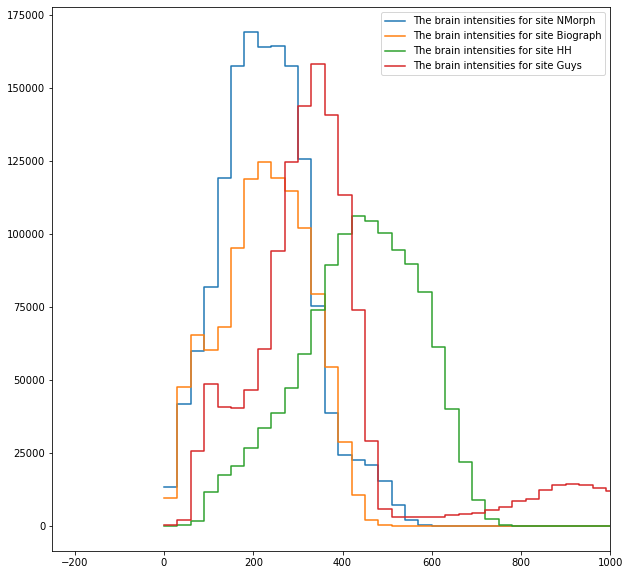

In [30]:
bins = np.arange(start=0, stop=1600, step=30)
plt.figure(figsize=(10,10))
res_mri = {}
for site in set(df['site']):
    res_mri[site] = []
    
dict_mri = df.to_dict('records')
for row in dict_mri:
    mri_id = row['sub_id']
    mri_raw_data = nib.load(f'./data/{mri_id}_raw.nii.gz').get_fdata()
    mri_brain_mask_data = nib.load(f'./data/{mri_id}_brainMask.nii.gz').get_fdata()
    
    mask_bool = np.where(mri_brain_mask_data > 0, True, False)
    hist = compute_histogram(mri_raw_data, mask_bool, bins)
    res_mri[row['site']].append(hist)

for site in res_mri:
    hist_res = np.zeros_like(res_mri[site][0])
    for hist in res_mri[site]:
        hist_res+=hist
    plot_histogram(hist_res/len(res_mri[site]), bins, label=f"The brain intensities for site {site}")

plt.xlim(right=1000)  
plt.xlim(left=-250) 
plt.legend()
plt.plot()

Plot these histograms with `plot_histogram`.

Note: You can use *matplotlib.pyplot.xlim* to change the limit of the x axis.

# Intensity normalization

## Z-score normalization

Z-score normalization standardizes the mean and the standard deviation of brain intensities within each MRI with the following formula:

$x_{zscore} = \frac{x_{base}-\mu_b}{\sigma_b}$
$\mu_b$ and $\sigma_b$ correspond respectively to mean and standard deviation of brain intensities within the original MRI $x_{base}$.

Create the function `zscore` that takes an MRI and the corresponding brain mask as arguments and returns the z-zcore normalized MRI.

In [32]:
def zscore(mri_data,mri_mask):
    mri_data_flat = mri_data.flatten()
    mask_data_flat = mri_mask.flatten()
    mri_brain_intes = mri_data_flat[mask_data_flat]
    mean_mri = np.mean(mri_brain_intes)
    std_mri = np.std(mri_brain_intes)
    return (mri_data - mean_mri)/std_mri

## Application to a single subject

Apply this function to subject 2 and print the mean and standard deviation of the brain intensities of the normalized image to verify that you find the correct values (0 and 1).

In [34]:
mri_raw_2_data = nib.load('./data/2_raw.nii.gz').get_fdata()
mri_brain_mask_2_data = nib.load('./data/2_brainMask.nii.gz').get_fdata()
mask_bool_2 = np.where(mri_brain_mask_2_data == 0, True, False)

#mri_data_flat = mri_raw_2_data.flatten()
#mask_data_flat = mask_bool_2.flatten()
##mri_brain_intes = mri_data_flat[mask_data_flat]
mri_brain_intes = np.where(mask_bool_2 == True, mri_raw_2_data, 0)

mean_mri = np.mean(mri_brain_intes)
std_mri = np.std(mri_brain_intes)

res_s_2 = (mri_raw_2_data - mean_mri)/std_mri
mean_mri, std_mri,res_s_2.mean(), res_s_2.std()

(230.13128646301533,
 422.99777695832546,
 0.32127614574666225,
 1.1533791072202983)

## Application to all subjects and histograms

Compute the average histogram of brain intensities for each site as you did previously but with z-score normalized images. This time we will use the following histogram bin edges: `np.arange(start=-4,stop=4,step=0.15)`.

In [35]:
bins = np.arange(start=-4, stop=4, step=0.15)

Now, plot the average histograms with `plot_histogram` as you did previously.

[]

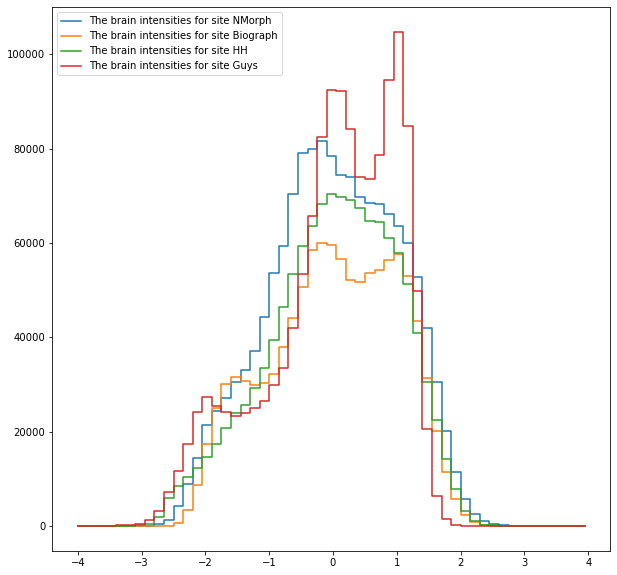

In [37]:
plt.figure(figsize=(10,10))
res_mri = {}
for site in set(df['site']):
    res_mri[site] = []
    
dict_mri = df.to_dict('records')
for row in dict_mri:
    mri_id = row['sub_id']
    mri_raw_data = nib.load(f'./data/{mri_id}_raw.nii.gz').get_fdata()
    mri_brain_mask_data = nib.load(f'./data/{mri_id}_brainMask.nii.gz').get_fdata()
    
    mask_bool = np.where(mri_brain_mask_data > 0, True, False)
    mri_raw_data_norm = zscore(mri_raw_data,mask_bool)
    hist = compute_histogram(mri_raw_data_norm, mask_bool, bins)
    res_mri[row['site']].append(hist)

for site in res_mri:
    hist_res = np.zeros_like(res_mri[site][0])
    for hist in res_mri[site]:
        hist_res+=hist
    plot_histogram(hist_res/len(res_mri[site]), bins, label=f"The brain intensities for site {site}")

plt.legend()
plt.plot()

Comment the histograms in comparison with those you obtained previously without z-score normalization.

Z-scores describe how data values compare to the mean by indicating how many standard deviations a value falls above or below the mean.
